In [49]:
#Perform all necessary imports

import os
import torch
from torch import nn, optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import functional as F
from torchvision.io import read_image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import cv2
import random
from PIL import Image

In [50]:
#Specify the path to the dataset

datasetpath = "./asldataset/asl_alphabet_train/asl_alphabet_train"

In [51]:
#Build a dataset that inherits from Pytorch Dataset. Perform normalization of image and append image path and labels to lists.

class ASLDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = read_image(img_path) / 255.0
        image = F.resize(image, [256, 256]) 

        return image, label


In [52]:
#Perform a 70% train 30% test split and 

dataset = ASLDataset(root_dir=datasetpath)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Total dataset size: {len(dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Total dataset size: 87000
Train dataset size: 60899
Test dataset size: 26101


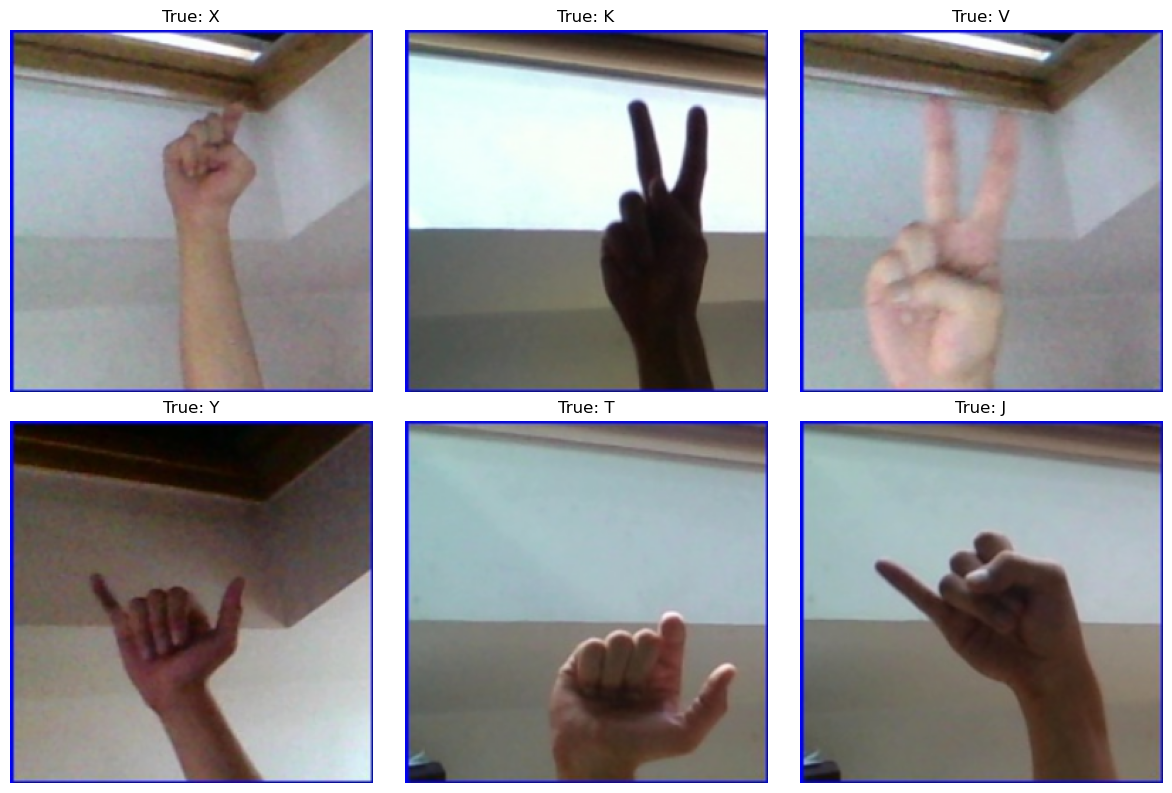

In [53]:
#Let's look at samples from our data

sampled_images = random.sample(range(len(dataset)), 6)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, idx in enumerate(sampled_images):
    img, label = dataset[idx]
    img = img.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].set_title(f"True: {dataset.classes[label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Processing Images: 100%|██████████| 952/952 [01:05<00:00, 14.52batch/s]


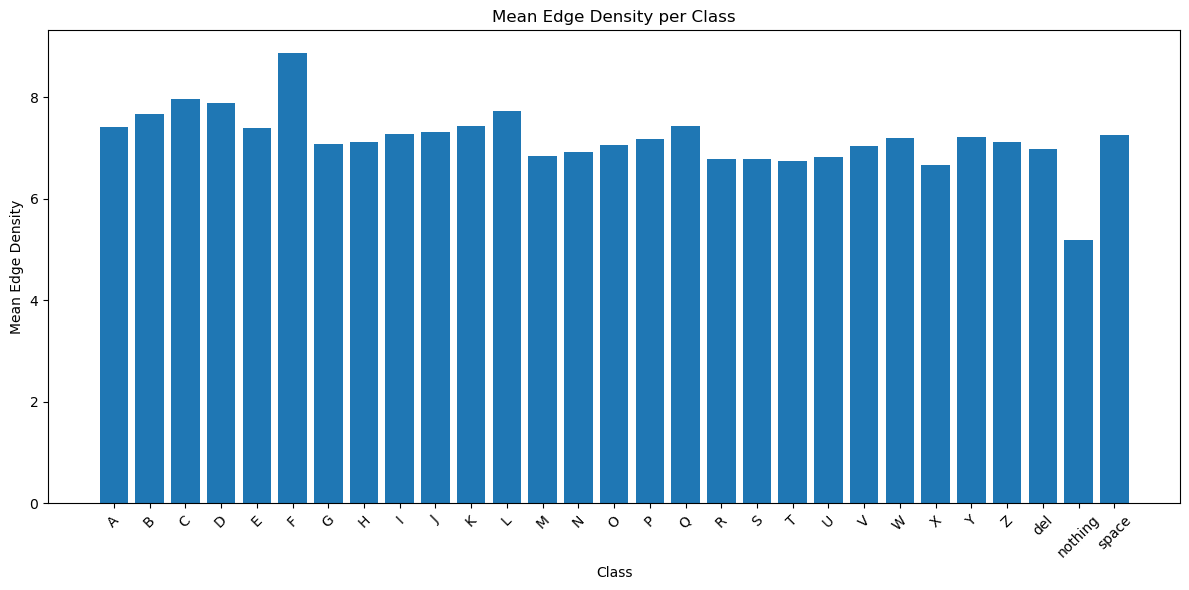

In [54]:
#Let's look at mean edge densities by class

class_edge_densities = {class_name: [] for class_name in dataset.classes}
for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Processing Images", unit="batch")):
    images = images.numpy()
    labels = labels.numpy()

    for img, label in zip(images, labels):
        img_gray = (img[0] * 255).astype(np.uint8)
        edges = cv2.Canny(img_gray, 100, 200)
        edge_density = np.sum(edges) / edges.size
        class_name = dataset.classes[label]
        class_edge_densities[class_name].append(edge_density)

classes = []
mean_densities = []
for class_name, densities in class_edge_densities.items():
    if densities:
        mean_edge_density = np.mean(densities)
        classes.append(class_name)
        mean_densities.append(mean_edge_density)

plt.figure(figsize=(12, 6))
plt.bar(classes, mean_densities)
plt.title('Mean Edge Density per Class')
plt.xlabel('Class')
plt.ylabel('Mean Edge Density')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
#Load the model, modify the final layer for our 29 classes, and put onto GPU

num_classes = len(dataset.classes)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\Vishnu\.conda\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vishnu\.conda\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [56]:
#Training loop

epochs = 2
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
        for images, labels in t:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images) #Get the model predictions
            loss = criterion(outputs, labels) #Apply Cross Entropy Loss on the predicted vars and targets

            optimizer.zero_grad() #Zero all gradients from previous loop
            loss.backward() #Do backpropogation, populating gradients
            optimizer.step() #Step in the direction of largest negative gradient, minimizing loss

            running_loss += loss.item() 
            _, predicted = outputs.max(1) #The output of the model is logits, so take the max of these to determine the predicted class
            total += labels.size(0) 
            correct += predicted.eq(labels).sum().item() #Update accuracy calculation

            t.set_postfix(loss=running_loss / (total / labels.size(0)), accuracy=100 * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")


Epoch 1/2: 100%|██████████| 952/952 [02:26<00:00,  6.49it/s, accuracy=98.2, loss=0.0374]


Epoch 1/2, Loss: 0.0684, Accuracy: 98.25%


Epoch 2/2: 100%|██████████| 952/952 [02:28<00:00,  6.43it/s, accuracy=99.6, loss=0.00712]

Epoch 2/2, Loss: 0.0130, Accuracy: 99.63%


In [57]:
#Perform evaluation on the test set

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


Classification Report:
              precision    recall  f1-score   support

           A    1.00000   1.00000   1.00000       889
           B    1.00000   1.00000   1.00000       965
           C    1.00000   1.00000   1.00000       934
           D    1.00000   1.00000   1.00000       914
           E    1.00000   1.00000   1.00000       889
           F    1.00000   1.00000   1.00000       912
           G    1.00000   1.00000   1.00000       884
           H    1.00000   1.00000   1.00000       964
           I    1.00000   1.00000   1.00000       919
           J    1.00000   1.00000   1.00000       889
           K    1.00000   1.00000   1.00000       931
           L    1.00000   1.00000   1.00000       872
           M    1.00000   0.99025   0.99510       923
           N    0.98990   1.00000   0.99492       882
           O    1.00000   1.00000   1.00000       889
           P    1.00000   1.00000   1.00000       890
           Q    1.00000   1.00000   1.00000       856
   

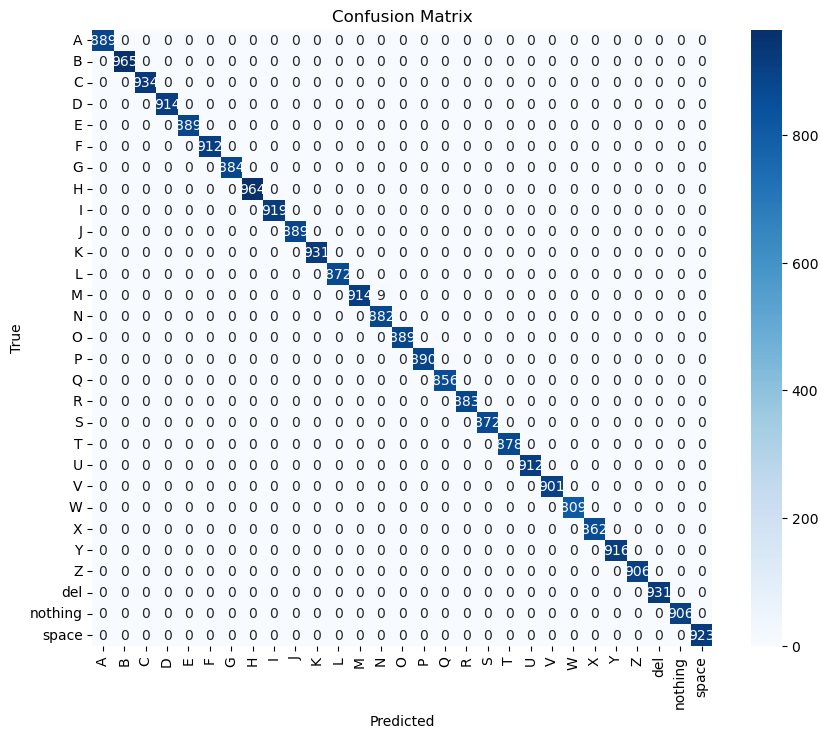

In [58]:
#Print classification report and confusion matrix

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes, digits=5))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


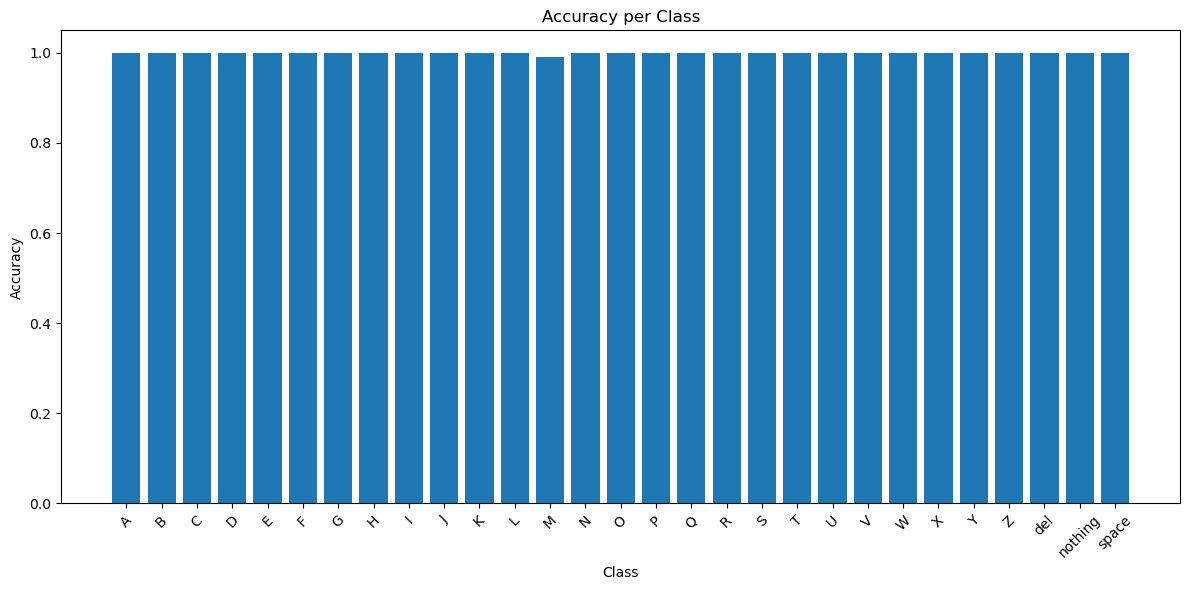

In [59]:
#Visualize accuracy by class

class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
classes = dataset.classes

plt.figure(figsize=(12, 6))
plt.bar(classes, class_accuracies)
plt.title('Accuracy per Class')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

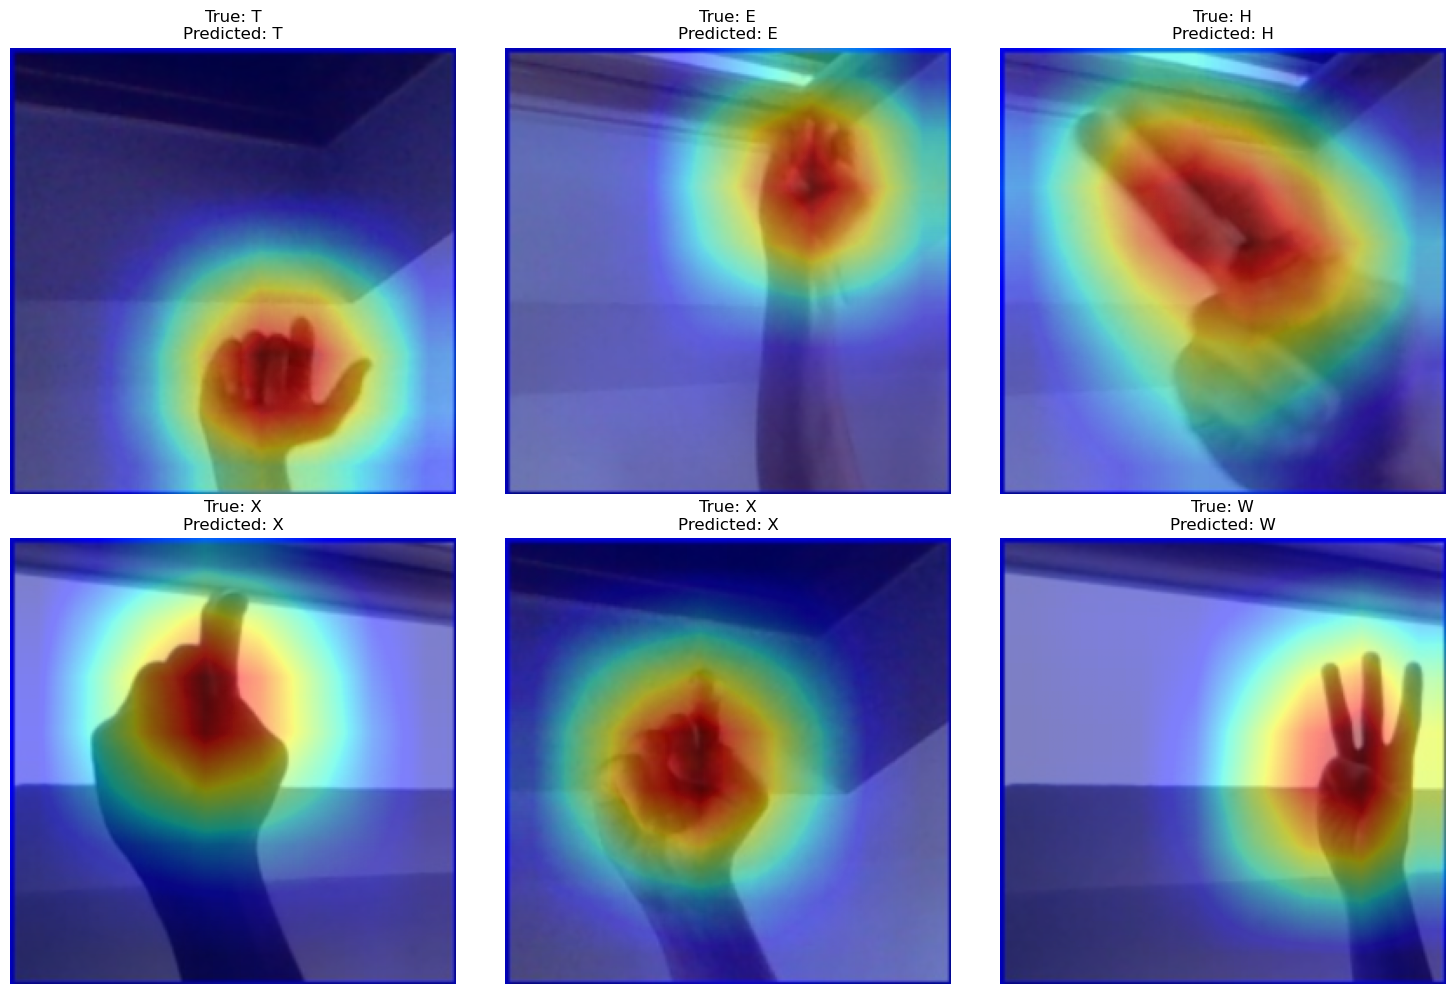

In [60]:
#Applying the method in: Learning Deep Features for Discriminative Localization, discussed more in the report

last_conv_layer = model.layer4[-1].conv2
activation_maps = []
def capture_features(module, input, output):
    activation_maps.append(output)
hook = last_conv_layer.register_forward_hook(capture_features)
def compute_cam(model, activation_maps, input_image, predicted_class_idx):
    fully_connected_weights = model.fc.weight[predicted_class_idx]
    cam = torch.zeros(activation_maps[0].shape[2:], dtype=torch.float32, device=input_image.device)
    for idx, weight in enumerate(fully_connected_weights):
        cam += weight * activation_maps[0][0, idx, :, :]
    cam = torch.nn.functional.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam.detach().cpu().numpy()

batch_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)
input_images, true_labels = next(iter(batch_loader))
input_images = input_images.cuda()
true_labels = true_labels.tolist()
model_outputs = model(input_images)
predicted_class_idx = model_outputs.argmax(dim=1).tolist()
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for idx in range(6):
    activation_maps.clear()  
    input_image_tensor = input_images[idx].unsqueeze(0)
    true_label = true_labels[idx]
    predicted_class = predicted_class_idx[idx]
    _ = model(input_image_tensor)  
    cam_image = compute_cam(model, activation_maps, input_image_tensor, predicted_class)
    cam_image = np.uint8(255 * cam_image)
    cam_image = Image.fromarray(cam_image).resize((256, 256), Image.BILINEAR)
    image_np = input_images[idx].permute(1, 2, 0).detach().cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    cam_np = np.array(cam_image)
    axs[idx].imshow(image_np)
    axs[idx].imshow(cam_np, cmap='jet', alpha=0.5)
    axs[idx].axis('off')
    axs[idx].set_title(f"True: {dataset.classes[true_label]}\nPredicted: {dataset.classes[predicted_class]}")

plt.tight_layout()
plt.show()